## Data Analysis (TEXT)

**TF-IDF**

TF calculates the fraction of a term in a document.

$$TF(t,d) = \frac{f_{t,d}}{\sum_{t' \in d}(f_{t',d})}$$

where $f_{t,d}$ is the count of term $t$ in document $d$.

IDF is calculated as

$$
\text{IDF}(t, d) = \log \left( \frac{N}{\left| \left\{ d \in D \mid t \in d \right\} \right|} \right)
$$

where N is the count of documents in the entire corpus. and $ \left\{ d \in D \mid t \in d \right\} $ is the set of documents containing term t. $\left| \left\{ d \in D \mid t \in d \right\} \right|$ is then the count of documents containing the term t. Summarized IDF returns the log inverse fraction of documents containing the term t in the corpus D.

Combined as the product of the two they give the TF-IDF

$$TFIDF(t,d,D) = tf(t,d)\cdot idf(t,D)$$

This function combines a terms importance within a single document (its internal representation) with its overall significance across the corpus.

In [181]:
import pandas as pd
import ast
import re
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0 
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from scipy.stats import chi2
from nltk.tokenize import MWETokenizer
import community as community_louvain
import networkx as nx
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import math

In [75]:
artists_text_path = "dummy_artists_with_lyrics.csv"

In [76]:
artists_df = pd.read_csv(artists_text_path)
artists_df["lyrics"] = artists_df["lyrics"].apply(ast.literal_eval)

artists_df.head()

,artist_name,lyrics
0,Kiana Ledé,[“EX” sees Kiana wanting to stay friends with ...
1,Yomi,[\n\nJeg skulle hørt på deg først\nOg ikke på ...
2,Ray Dalton,"[\nWake up in Manila, ride to Belize\nDive int..."
3,Juice,"[On “Lucid Dreams,” Juice WRLD explores the me..."
4,Agnes,"[\nOoh, ooh\nAll the time boy, need you all th..."


Graph that we are going to work on.

In [118]:
final_cleaned_nodes_df = pd.read_csv("nodes_df.csv")
final_cleaned_nodes_df["genres"] = final_cleaned_nodes_df["genres"].apply(ast.literal_eval)

edges_df = pd.read_csv("edges.csv")

In [123]:
def split_artists_by_genre(nodes_df, genre_names, exclusive=False):    
    nodes_df = nodes_df.copy()

    filtered_dfs = []

    for genre in genre_names:
        if exclusive:
            other_genres = [g for g in genre_names if g != genre]
            
            df = nodes_df[
                nodes_df['genres'].apply(
                    lambda genres: genre in ' '.join(genres) and all(other not in ' '.join(genres) for other in other_genres)
                )
            ].copy()
        else:
             df = nodes_df[
                nodes_df['genres'].apply(
                    lambda genres: genre in ' '.join(genres)
                )
            ].copy()
                     
        filtered_dfs.append(df)

    return filtered_dfs

def get_Graph_with_names(nodes_df, edges_df, verbose=True):
    nodes_df = nodes_df.dropna(subset=['spotify_id', 'name'])
    edges_df = edges_df.dropna(subset=['id_0', 'id_1'])

    # Build ID to name map
    id_to_name = dict(zip(nodes_df['spotify_id'], nodes_df['name']))
    allowed_ids = set(id_to_name.keys())

    # Create graph with artist names as nodes
    G = nx.Graph()

    for _, row in nodes_df.iterrows():
        artist_name = row['name']
        followers = row['followers'] if not pd.isna(row['followers']) else 0
        popularity = row['popularity'] if not pd.isna(row['popularity']) else 0
        genres = row['genres']
        chart_hits = row['chart_hits'] if not pd.isna(row['chart_hits']) else []

        G.add_node(artist_name, followers=followers, popularity=popularity,
                   genres=genres, chart_hits=chart_hits)

    for _, row in edges_df.iterrows():
        id_0, id_1 = row['id_0'], row['id_1']
        if id_0 in allowed_ids and id_1 in allowed_ids:
            name_0 = id_to_name.get(id_0)
            name_1 = id_to_name.get(id_1)
            if name_0 and name_1:
                G.add_edge(name_0, name_1)

    if verbose:
        print(f"Number of nodes: {G.number_of_nodes()}")
        print(f"Number of edges: {G.number_of_edges()}")
        print(f"Network density: {nx.density(G)}")

    return G

def get_n_largest_component(G, n):
    return sorted(nx.connected_components(G), key=len, reverse=True)[n]

def apply_louvain(G, verbose=True):
    partition = community_louvain.best_partition(G)

    nx.set_node_attributes(G, partition, 'community')
    
    if verbose:
        community_sizes = Counter(partition.values())
        sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)
        for community_id, size in sorted_communities:
            print(f"Community {community_id}: {size} nodes")
    
    communities = defaultdict(list)
    for node, community_id in partition.items():
        communities[community_id].append(node)
    
    sorted_communities = sorted(communities.items(), key=lambda x: len(x[1]), reverse=True)
    return sorted_communities
        
def get_community_subgraph(G, community_id):
    nodes_in_community = [n for n, attr in G.nodes(data=True) if attr.get('community') == community_id]
    
    subgraph = G.subgraph(nodes_in_community).copy()
    
    return subgraph

def get_combined_louvain_splitted_graph(G):
    _G = G.copy()
    partition = community_louvain.best_partition(_G)
    nx.set_node_attributes(_G, partition, 'community')

    combined_G = nx.Graph()
    
    combined_G.add_nodes_from(_G.nodes(data=True))

    for u, v in _G.edges():
        if partition[u] == partition[v]:
            combined_G.add_edge(u, v, **_G[u][v])

    return combined_G

def print_top_collaborators(G, n):
    top_collaborators = sorted(G.degree, key=lambda x: x[1], reverse=True)[:n]

    print(f"Top {n} artists with the most collaborations:")
    for rank, (artist, degree) in enumerate(top_collaborators, start=1):
        print(f"{rank}. {artist} — {degree} collaborations")

pop_df, rap_df = split_artists_by_genre(final_cleaned_nodes_df, ["pop", "rap"])

len(pop_df), len(rap_df)

(4413, 1735)

In [124]:
G_pop = get_Graph_with_names(pop_df, edges_df)
G_rap = get_Graph_with_names(rap_df, edges_df)

Number of nodes: 4413
Number of edges: 17789
Network density: 0.001827309447340843
Number of nodes: 1735
Number of edges: 11943
Network density: 0.007939531126910843


Prepare a mapping from artist to community

In [138]:
rap_degrees_dict = dict(G_rap.degree())
rap_artist_to_community= community_louvain.best_partition(G_rap)
rap_artist_community_df = pd.DataFrame({
    "artist_name": list(rap_artist_to_community.keys()),
    "community_id": list(rap_artist_to_community.values()),
    "degree": [rap_degrees_dict[a] for a in rap_artist_to_community.keys()]
})


pop_degrees_dict = dict(G_pop.degree())
pop_artist_to_community = community_louvain.best_partition(G_pop)
pop_artist_community_df = pd.DataFrame({
    "artist_name": list(pop_artist_to_community.keys()),
    "community_id": list(pop_artist_to_community.values()),
    "degree": [pop_artist_to_community[a] for a in pop_artist_to_community.keys()]
})

rap_artist_community_df.head()

,artist_name,community_id,degree
0,Drake,0,66
1,Eminem,0,39
2,Bad Bunny,1,76
3,Post Malone,0,38
4,XXXTENTACION,0,23


Cleaning of the lyrics and aggregating them into one comibned representative text

In [130]:
def join_and_clean(lyrics):
    cleaned = []
    
    for raw_lyrics in lyrics:
        # intro before "Read More\xa0\n"
        parts = raw_lyrics.split("Read More\xa0\n")
        lyrics = parts[-1] if parts else raw_lyrics

        # Remove first line often title/commentary
        lyrics_parts = lyrics.split('\n', 1)
        lyrics = lyrics_parts[1] if len(lyrics_parts) > 1 else lyrics_parts[0]

        # Remove [Verse], [Chorus], etc.
        lyrics = re.sub(r'\[.*?\]', '', lyrics)

        # Remove commentary
        lyrics = re.sub(r'^“.*?”\s*', '', lyrics)
        
        lyrics = re.sub(r'[^a-zA-Z\s]', '', lyrics)  # Only letters and spaces

        #Clean escaped characters and whitespace
        lyrics = re.sub(r'\\n|\\r|\r|\n', ' ', lyrics)
        lyrics = re.sub(r'\s+', ' ', lyrics).strip()
        
        lyrics = lyrics.lower()

        cleaned.append(lyrics)

    
    return " ".join(cleaned)

In [78]:
artists_df["representative_text"] = artists_df["lyrics"].apply(join_and_clean)

In [79]:
artists_df.head()

,artist_name,lyrics,representative_text
0,Kiana Ledé,[“EX” sees Kiana wanting to stay friends with ...,we went from am calls to zero communication ye...
1,Yomi,[\n\nJeg skulle hørt på deg først\nOg ikke på ...,jeg skulle hrt p deg frst og ikke p meg selv o...
2,Ray Dalton,"[\nWake up in Manila, ride to Belize\nDive int...",wake up in manila ride to belize dive into the...
3,Juice,"[On “Lucid Dreams,” Juice WRLD explores the me...",no no no no nono no no no no no no no no no no...
4,Agnes,"[\nOoh, ooh\nAll the time boy, need you all th...",ooh ooh all the time boy need you all the time...


Filter the dataframe for english speaking artists

In [85]:
def is_english(text):
    try:
        return detect(text) == "en"
    except:
        return False

artists_df["is_english"] = artists_df["representative_text"].apply(is_english)

english_artists_df = artists_df[artists_df["is_english"]].reset_index(drop=True)

print(f"Found {len(english_artists_df)} english artists")

english_artists_df.head()

Found 1515 english artists


,artist_name,lyrics,representative_text,is_english
0,Kiana Ledé,[“EX” sees Kiana wanting to stay friends with ...,we went from am calls to zero communication ye...,True
1,Ray Dalton,"[\nWake up in Manila, ride to Belize\nDive int...",wake up in manila ride to belize dive into the...,True
2,Juice,"[On “Lucid Dreams,” Juice WRLD explores the me...",no no no no nono no no no no no no no no no no...,True
3,Agnes,"[\nOoh, ooh\nAll the time boy, need you all th...",ooh ooh all the time boy need you all the time...,True
4,MKTO,[“Classic” is a song by American pop duo MKTO....,hey wheres the drums woo ohohoh lets go ooh gi...,True


Prepare tokenization by using Snowballstemmer and using english with domain stopwords

In [95]:
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words("english"))

domain_stopwords = {"song", "lyrics", "chorus", "verse", "repeat"}

stop_words = stop_words.union(domain_stopwords)

list(stop_words)[:9]

['him', 'all', 'not', 'she', 'until', 'having', "it's", 'more', 'then']

In [97]:
def tokenizer(text):
    text = text.lower()
    words = re.findall(r'[a-zA-Z]+', text)
    return [stemmer.stem(word) for word in words if word not in stop_words]

english_artists_df["tokens"] = english_artists_df["representative_text"].apply(tokenizer)

english_artists_df.head()

,artist_name,lyrics,representative_text,is_english,tokens
0,Kiana Ledé,[“EX” sees Kiana wanting to stay friends with ...,we went from am calls to zero communication ye...,True,"[went, call, zero, communic, yeah, spent, long..."
1,Ray Dalton,"[\nWake up in Manila, ride to Belize\nDive int...",wake up in manila ride to belize dive into the...,True,"[wake, manila, ride, beliz, dive, ocean, feel,..."
2,Juice,"[On “Lucid Dreams,” Juice WRLD explores the me...",no no no no nono no no no no no no no no no no...,True,"[nono, still, see, shadow, room, cant, take, b..."
3,Agnes,"[\nOoh, ooh\nAll the time boy, need you all th...",ooh ooh all the time boy need you all the time...,True,"[ooh, ooh, time, boy, need, time, boy, ooh, oo..."
4,MKTO,[“Classic” is a song by American pop duo MKTO....,hey wheres the drums woo ohohoh lets go ooh gi...,True,"[hey, where, drum, woo, ohohoh, let, go, ooh, ..."


Create one big document containing all the tokens. Then find bigrams and retokentize the tokens such that bigrams with a frequency higher than 50 are included.

In [101]:
all_tokens = [token for tokens in english_artists_df["tokens"] for token in tokens]

finder = BigramCollocationFinder.from_words(all_tokens)
finder.apply_freq_filter(51)

bigram_measures = BigramAssocMeasures()
scored = finder.score_ngrams(bigram_measures.chi_sq)

collocations = []
for bigram, score in scored:
    p_value = chi2.sf(score, df=1)
    if p_value < 0.001:
        collocations.append(bigram)

mwe_tokenizer = MWETokenizer(collocations, separator="_")

def retokenize(tokens):
    return mwe_tokenizer.tokenize(tokens)

english_artists_df["tokens"] = english_artists_df["tokens"].apply(retokenize)

english_artists_df.head()

,artist_name,lyrics,representative_text,is_english,tokens
0,Kiana Ledé,[“EX” sees Kiana wanting to stay friends with ...,we went from am calls to zero communication ye...,True,"[went, call, zero, communic, yeah, spent, long..."
1,Ray Dalton,"[\nWake up in Manila, ride to Belize\nDive int...",wake up in manila ride to belize dive into the...,True,"[wake, manila, ride, beliz, dive, ocean, feel,..."
2,Juice,"[On “Lucid Dreams,” Juice WRLD explores the me...",no no no no nono no no no no no no no no no no...,True,"[nono, still, see, shadow, room, cant_take, ba..."
3,Agnes,"[\nOoh, ooh\nAll the time boy, need you all th...",ooh ooh all the time boy need you all the time...,True,"[ooh_ooh, time, boy, need, time, boy, ooh_ooh,..."
4,MKTO,[“Classic” is a song by American pop duo MKTO....,hey wheres the drums woo ohohoh lets go ooh gi...,True,"[hey, where, drum, woo, ohohoh, let_go, ooh, g..."


**Now we can aggregate a representative text for each community**

In [166]:
rap_english_artist_df = english_artists_df.copy()
rap_english_artist_df["community"] = rap_english_artist_df["artist_name"].map(rap_artist_to_community)
rap_english_artist_df = rap_english_artist_df.dropna()

pop_english_artist_df = english_artists_df.copy()
pop_english_artist_df["community"] = pop_english_artist_df["artist_name"].map(pop_artist_to_community)
pop_english_artist_df = pop_english_artist_df.dropna()

print(f"Found {len(rap_english_artist_df)} english artists within rap, singing english and within our lyrics set")
print(f"Found {len(pop_english_artist_df)} english artists within pop, singing english and within our lyrics set")

rap_grouped_by_community = rap_english_artist_df.groupby("community")
pop_grouped_by_community = pop_english_artist_df.groupby("community")

print(f"{len(rap_grouped_by_community)} rap communities.")
print(f"{len(pop_grouped_by_community)} pop communities.")

rap_community_texts = rap_grouped_by_community["tokens"].apply(lambda series: sum(series, [])).reset_index()
pop_community_texts = pop_grouped_by_community["tokens"].apply(lambda series: sum(series, [])).reset_index()

rap_community_texts["tokens_length"] = rap_community_texts["tokens"].apply(lambda tokens : len(tokens)) 
pop_community_texts["tokens_length"] = pop_community_texts["tokens"].apply(lambda tokens : len(tokens)) 


rap_community_texts.head()

Found 162 english artists within rap, singing english and within our lyrics set
Found 527 english artists within pop, singing english and within our lyrics set
10 rap communities.
82 pop communities.


,community,tokens,tokens_length
0,0.0,"[mustard, beat, ho, give, got, make, want_caus...",133788
1,1.0,"[gave, went, threw, door, everyth, ask, took, ...",7188
2,13.0,"[there, mani, thing, wish, didnt, continu, lea...",283
3,16.0,"[select, best, new, track, pitchfork, wrote, o...",1031
4,30.0,"[eh_eh, eh_eh, whoa_oh, oh_oh_oh_oh, ive_wait,...",522


**Calculating TF values for tokens within the top 5 communities**

In [151]:
rap_community_counts = Counter(rap_artist_to_community.values()) # get the counts of each artist and commmunity pair
rap_sorted_communities_by_counts = sorted(rap_community_counts.items(), key=lambda x: x[1], reverse=True) # sort in descending by count.

pop_community_counts = Counter(pop_artist_to_community.values()) # get the counts of each artist and commmunity pair
pop_sorted_communities_by_counts = sorted(pop_community_counts.items(), key=lambda x: x[1], reverse=True) # sort in descending by count.

rap_top_5_community_ids = np.array([id_and_count[0] for id_and_count in rap_sorted_communities_by_counts[:5]])
pop_top_5_community_ids = np.array([id_and_count[0] for id_and_count in pop_sorted_communities_by_counts[:5]])

print(f"Found the top 5 community ids within rap as {rap_top_5_community_ids}")
print(f"Found the top 5 community ids within pop as {pop_top_5_community_ids}")

Found the top 5 community ids within rap as [ 0  1 16 15  7]
Found the top 5 community ids within pop as [ 0  3 56  1 13]


In [167]:
rap_top_5_communities = rap_community_texts[rap_community_texts["community"].isin(rap_top_5_community_ids)]
pop_top_5_communities = pop_community_texts[pop_community_texts["community"].isin(pop_top_5_community_ids)]

rap_top_5_communities

,community,tokens,tokens_length
0,0.0,"[mustard, beat, ho, give, got, make, want_caus...",133788
1,1.0,"[gave, went, threw, door, everyth, ask, took, ...",7188
3,16.0,"[select, best, new, track, pitchfork, wrote, o...",1031


In [168]:
def get_TF_dataframe(top_5_communities):
    top_5_communities_expanded = top_5_communities.copy() # Copy top 5 communities to not make a mess
    exploded = top_5_communities_expanded.explode("tokens") # Explode into tokens

    token_counts  = exploded.groupby(["community", "tokens"]).size().reset_index(name="count")
    # group inside each community and get the token count store it in column "count"

    total_tokens = exploded.groupby("community").size().reset_index(name="total")
    # Group only by community such we can get the total counts

    tf_df = token_counts.merge(total_tokens, on="community") # Merge total_tokens onto token_counts so we can divide after and get the TF

    tf_df["TF"] = tf_df["count"] / tf_df["total"]
    
    return tf_df

rap_tf_df = get_TF_dataframe(rap_top_5_communities)
pop_tf_df = get_TF_dataframe(pop_top_5_communities)

rap_tf_df.head()


,community,tokens,count,total,TF
0,0.0,aaaaaaaaaalcohol,5,133788,0.000037
1,0.0,aaaaaalcohol,13,133788,0.000097
2,0.0,aaaint,1,133788,0.000007
3,0.0,aaass,1,133788,0.000007
4,0.0,aagh,1,133788,0.000007


In [169]:
def print_top_5_TF_per_community(tf_df):
    sorted_descending_by_tf = tf_df.sort_values(["TF"], ascending=[False]) # Sort it decending order by TF such term with highest TF is up.
    top_5_per_community = sorted_descending_by_tf.groupby("community").head(5).reset_index()
    # Grouping by community to then get the 5 largest by .head(5) as they are sorted descendingly. Finnaly reshaping back using reset_index.

    top_5_per_community_sorted = top_5_per_community.sort_values(["community"]) # sort such we get the terms 
    # for each community next to each other. Easier when printing

    print(f"{len(top_5_per_community_sorted)} terms")

    for i in range(0,len(top_5_per_community_sorted),5):
        print(f"Community: {top_5_per_community_sorted.iloc[i]["community"]}, 5 Terms: {top_5_per_community_sorted[i: i+5]["tokens"].to_list()}")

print("---Rap---")
print_top_5_TF_per_community(rap_tf_df)
print("---Pop---")
print_top_5_TF_per_community(pop_tf_df)


---Rap---
15 terms
Community: 0.0, 5 Terms: ['im', 'like', 'got', 'nigga', 'yeah']
Community: 1.0, 5 Terms: ['im', 'que', 'lo', 'es', 'love']
Community: 16.0, 5 Terms: ['love_that', 'shit', 'like', 'im', 'fuck']
---Pop---
25 terms
Community: 0.0, 5 Terms: ['like', 'im', 'love', 'your', 'oh']
Community: 1.0, 5 Terms: ['got', 'like', 'im', 'nigga', 'yeah']
Community: 3.0, 5 Terms: ['la', 'oh', 'que', 'im', 'love']
Community: 13.0, 5 Terms: ['addict', 'yeah', 'unit', 'write', 'boy']
Community: 56.0, 5 Terms: ['like', 'got', 'watch', 'bounc_bounc', 'go']


In [171]:
def get_IDF_dataframe(community_texts):
    community_texts_expanded = community_texts.copy() # Copy the community text to not make a mess
    exploded = community_texts_expanded.explode("tokens") # Explode into tokens

    print(f"{len(exploded)} tokens...")

    community_token_pairs = exploded[["community", "tokens"]].drop_duplicates() 
    # Removing all duplicates as we just need to know if community i has token j.

    token_to_community_count = community_token_pairs.groupby("tokens").size().reset_index(name="tokenInCommunityCount") 
    # Count how many communities the token exists in.

    N = len(community_texts)

    IDF_df = token_to_community_count
    IDF_df["idf"] = np.log(N / IDF_df["tokenInCommunityCount"])

    return IDF_df
    
rap_IDF_df = get_IDF_dataframe(rap_community_texts)
pop_IDF_df = get_IDF_dataframe(pop_community_texts)

rap_IDF_df.head()

146343 tokens...
317811 tokens...


,tokens,tokenInCommunityCount,idf
0,aaa,1,2.302585
1,aaaaaaaaaalcohol,1,2.302585
2,aaaaaalcohol,1,2.302585
3,aaaint,1,2.302585
4,aaass,1,2.302585


In [173]:
def get_TF_IDF_dataframe(tf_df, IDF_df):
    tf_idf_df = tf_df.copy().merge(IDF_df[["tokens", "idf"]], on="tokens", how="left") # Merge the idf_values onto each token in tf_df. 
    # To prepare for calculating the tf-idf value.

    tf_idf_df["tf-idf"] = tf_idf_df["TF"] * tf_idf_df["idf"]

    return tf_idf_df

rap_TF_IDF_df = get_TF_IDF_dataframe(rap_tf_df, rap_IDF_df)
pop_TF_IDF_df = get_TF_IDF_dataframe(pop_tf_df, pop_IDF_df)

rap_TF_IDF_df.head()

,community,tokens,count,total,TF,idf,tf-idf
0,0.0,aaaaaaaaaalcohol,5,133788,0.000037,2.302585,0.000086
1,0.0,aaaaaalcohol,13,133788,0.000097,2.302585,0.000224
2,0.0,aaaint,1,133788,0.000007,2.302585,0.000017
3,0.0,aaass,1,133788,0.000007,2.302585,0.000017
4,0.0,aagh,1,133788,0.000007,2.302585,0.000017


In [174]:
def print_top_10_tf_idf_tokens(tf_idf_df):
    sorted_descending_by_tf_idf = tf_idf_df.sort_values(["tf-idf"], ascending=[False]) # Sort it decending order by 'tf-idf' such term with 
    # highest tf-idf is furthest up.
    top_10_per_community = sorted_descending_by_tf_idf.groupby("community").head(10).reset_index()
    # Grouping by community to then get the 10 largest using .head(10) as they are sorted descendingly. Finnaly reshaping back using reset_index.

    top_10_per_community_sorted = top_10_per_community.sort_values(["community"]) # sort such we get the terms 
    # for each community next to each other. Easier when printing

    print(f"{len(top_10_per_community_sorted)} terms")

    for i in range(0, len(top_10_per_community_sorted), 10):
        print(f"Community: {top_10_per_community_sorted.iloc[i]["community"]}, 10 Terms: {top_10_per_community_sorted[i: i+10]["tokens"].to_list()}")

print("---Rap---")        
print_top_10_tf_idf_tokens(rap_TF_IDF_df)
print("---Pop---")
print_top_10_tf_idf_tokens(pop_TF_IDF_df)


---Rap---
30 terms
Community: 0.0, 10 Terms: ['nigga', 'pussi', 'yeah', 'shit', 'ima', 'fuck', 'ayi', 'big', 'woo', 'bitch']
Community: 1.0, 10 Terms: ['una', 'que', 'montana', 'sabe', 'lo', 'es', 'amor', 'te', 'el', 'toni']
Community: 16.0, 10 Terms: ['ohoh_ohoh', 'love_that', 'fuck', 'toward', 'motherfuckin', 'shit_im', 'lift', 'tonight', 'cannot', 'sky']
---Pop---
50 terms
Community: 0.0, 10 Terms: ['got', 'your', 'fuck', 'low_low_low_low', 'ooh', 'im', 'ya', 'hey', 'cant', 'yeah']
Community: 1.0, 10 Terms: ['bitch', 'nigga', 'got', 'money', 'yeah', 'fuck', 'aint', 'pussi', 'shit', 'gon']
Community: 3.0, 10 Terms: ['lento', 'coocoocoocoo', 'que', 'est', 'lo', 'la', 'el', 'un', 'sabe', 'te']
Community: 13.0, 10 Terms: ['pam', 'addict', 'im_addict', 'unit', 'march', 'yeaheaheah', 'write', 'uhlala', 'bye_bye', 'eh_eh']
Community: 56.0, 10 Terms: ['bop_bop', 'twerkin', 'side_side', 'miley', 'bounc_bounc', 'bounc', 'ooh_ooh_ooh_ooh', 'trampolin', 'robberi', 'wanna_danc']


In [176]:
def get_community_to_top_3_artists(top_5_communities, artist_community_dict, degrees_dict):
    community_to_top_3_artists = defaultdict(list) # initialise default dict.

    for community in top_5_communities["community"]: # loop each community
        comunity_authors = [author for author, _community in artist_community_dict.items() if _community == community] 
        # filter authors for given community
        sorted_authors_by_degree = sorted(comunity_authors, key=lambda x: degrees_dict[x], reverse=True) 
        # sort authors in descending order by their degrees using degrees_dict
        community_to_top_3_artists[community] = sorted_authors_by_degree[:3] # store top 3 for later
        print(f"The top 3 authors by degree in community {community} are with ids: {', '.join(sorted_authors_by_degree[:3])}") # print top 3
        
    return community_to_top_3_artists

print("---Rap---")
rap_community_to_top_3_artists = get_community_to_top_3_artists(rap_top_5_communities, rap_artist_to_community, rap_degrees_dict)

print("---Pop---")
pop_community_to_top_3_artists = get_community_to_top_3_artists(pop_top_5_communities, pop_artist_to_community, pop_degrees_dict)

---Rap---
The top 3 authors by degree in community 0.0 are with ids: Ty Dolla $ign, Gucci Mane, French Montana
The top 3 authors by degree in community 1.0 are with ids: Farruko, De La Ghetto, Rauw Alejandro
The top 3 authors by degree in community 16.0 are with ids: Massaka, Anıl Piyancı, Ufo361
---Pop---
The top 3 authors by degree in community 0.0 are with ids: R3HAB, David Guetta, Steve Aoki
The top 3 authors by degree in community 1.0 are with ids: Ty Dolla $ign, Snoop Dogg, French Montana
The top 3 authors by degree in community 3.0 are with ids: Juan Magán, Becky G, Sebastian Yatra
The top 3 authors by degree in community 13.0 are with ids: Lacrim, Soprano, Dadju
The top 3 authors by degree in community 56.0 are with ids: Petter, HEDEGAARD, Cherrie


In [182]:
def plot_wordcloud(tf_idf_df, top_communities, community_to_top_3_authors):
    n = 100  # Number of top tokens per community

    # Sort by tf-idf score descending
    sorted_descending_by_tf_idf = tf_idf_df.sort_values("tf-idf", ascending=False)

    # Get top-n per community
    top_n_per_community = (
        sorted_descending_by_tf_idf.groupby("community").head(n).reset_index(drop=True)
    )

    # Sort by community number
    top_n_per_community_sorted = top_n_per_community.sort_values("community")

    print(f"{len(top_n_per_community_sorted)} terms")

    num_communities = len(top_communities)
    cols = 3  # You can change this default
    rows = math.ceil(num_communities / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    axes = axes.flatten()

    for idx, community in enumerate(top_communities["community"]):
        top_words_df = top_n_per_community_sorted[
            top_n_per_community_sorted["community"] == community
        ]
        word_freq = dict(zip(top_words_df["tokens"], top_words_df["tf-idf"]))

        authors = community_to_top_3_authors.get(community, [])
        author_str = "\n".join(authors)

        wc = WordCloud(width=800, height=600, background_color="white").generate_from_frequencies(word_freq)

        axes[idx].imshow(wc, interpolation="bilinear")
        axes[idx].set_title(f"Community {community}\n\n{author_str}", fontsize=14, pad=20)
        axes[idx].axis("off")

    # Turn off any extra axes (if grid > number of communities)
    for j in range(num_communities, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

300 terms


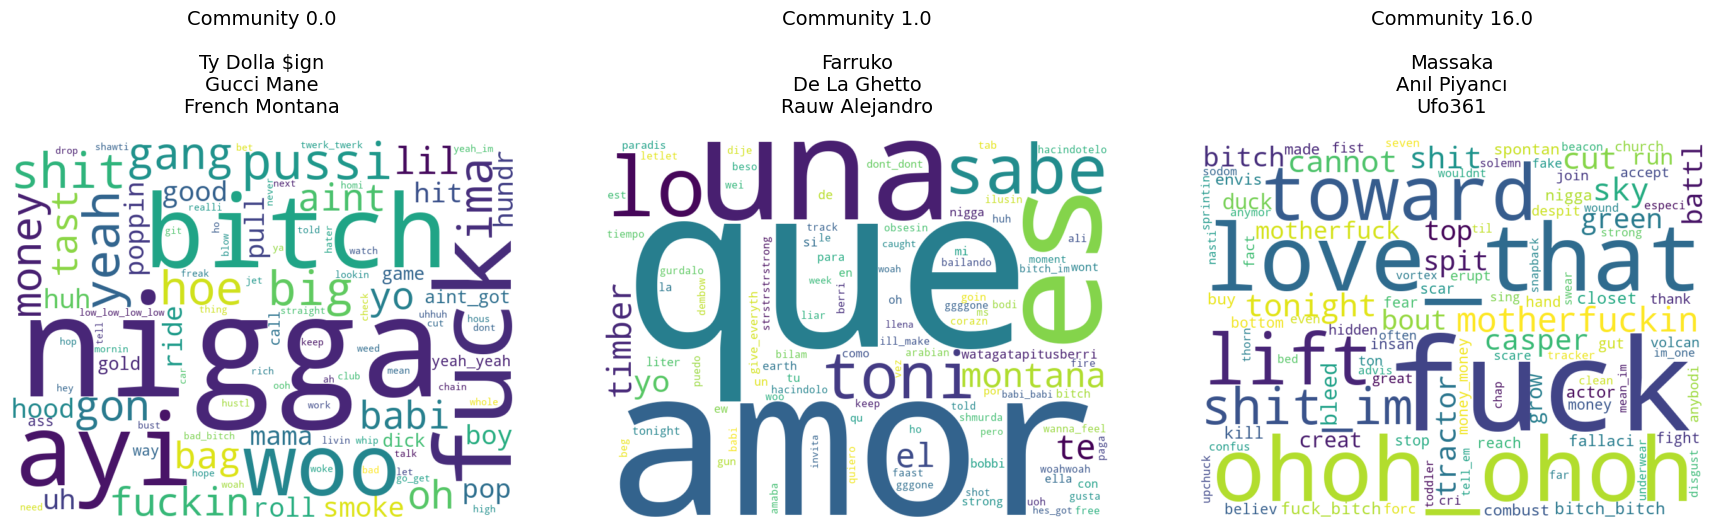

In [183]:
plot_wordcloud(rap_TF_IDF_df, rap_top_5_communities, rap_community_to_top_3_artists)

500 terms


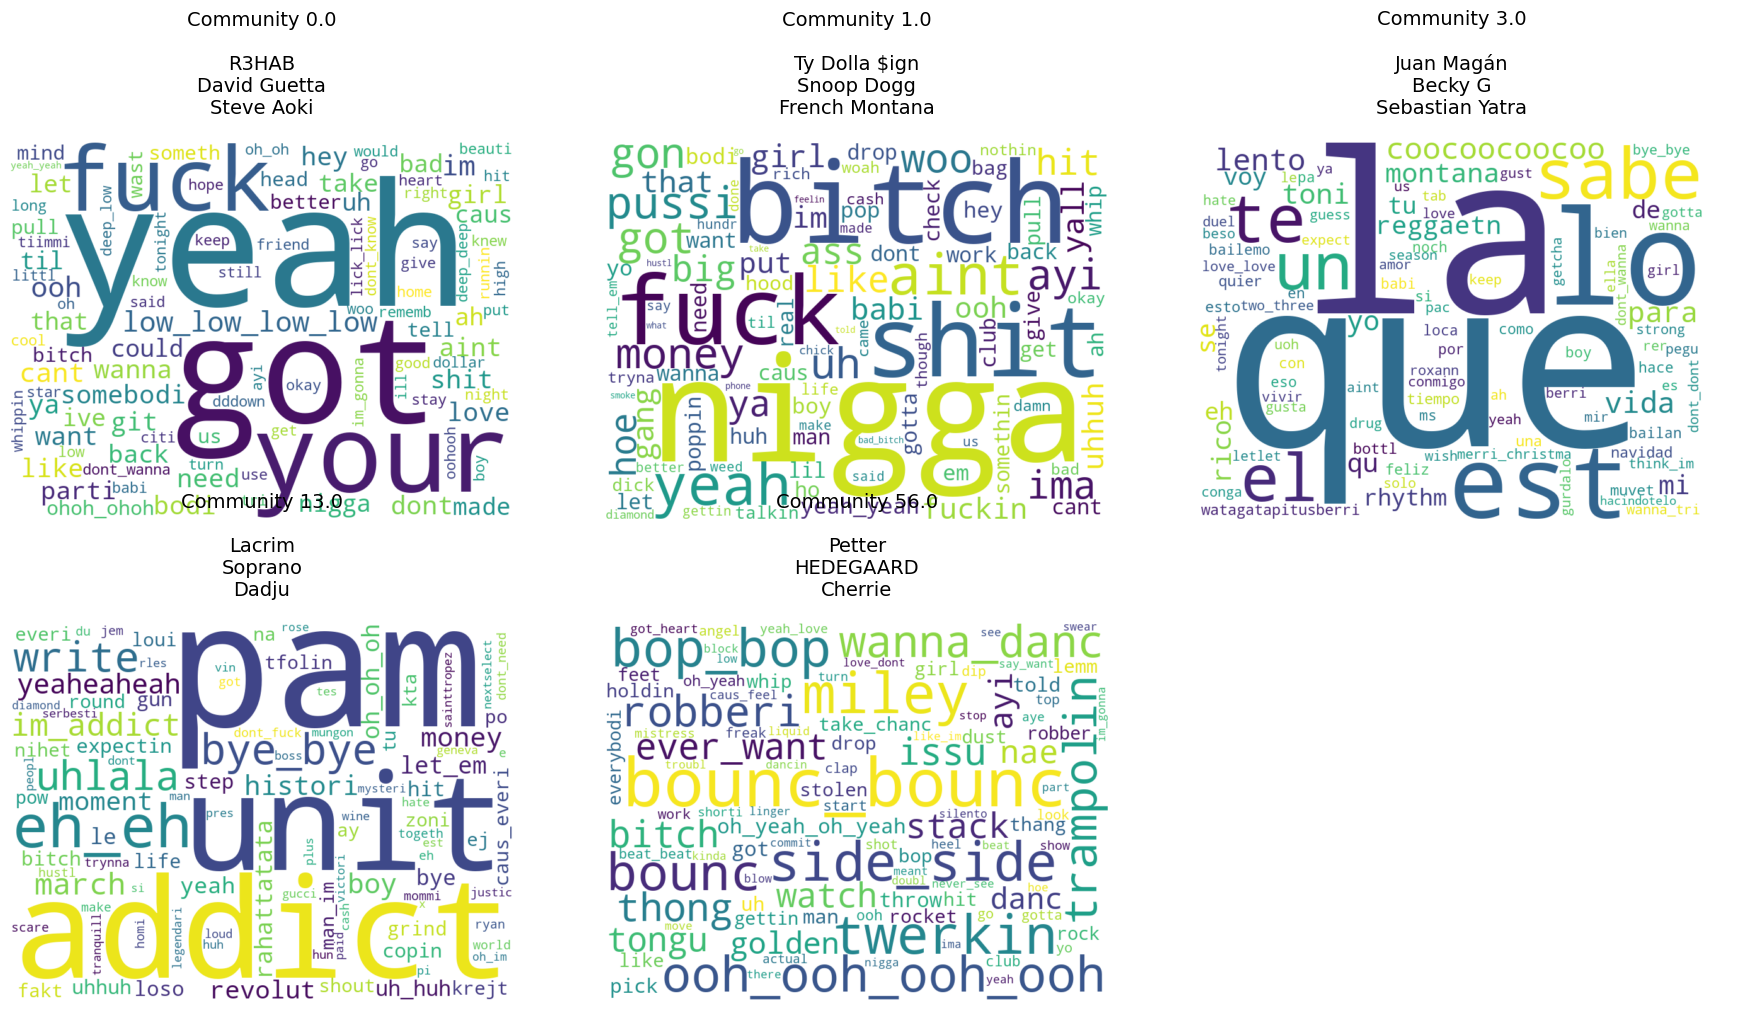

In [184]:
plot_wordcloud(pop_TF_IDF_df, pop_top_5_communities, pop_community_to_top_3_artists)